# Problem Description


Build a Transfer learning model to detect face masks on humans.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

2025-04-27 12:54:47.257369: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-27 12:54:47.257940: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:54:47.260227: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 12:54:47.265656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745776487.275677    6643 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745776487.27

# Dataset Description

The zip folder contains 2 folders train and test each folder with 2 subfolders labelled as to which class they belong to. 

The 2 classes are 

- "with_mask"
- "without_mask"

Each image is of shape 128, 128, 3.

In [2]:
import os
import shutil
import random

def organize_images(folder_groups, output_dir='processed_data', split_ratio=0.8):
    """
    folder_groups: list of tuples, each like (class_name, [folder1, folder2, ...])
    output_dir: base output directory
    split_ratio: proportion of data to be used for training
    """
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')

    # Create destination folders
    for class_name, _ in folder_groups:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Go through each class group
    for class_name, source_folders in folder_groups:
        all_files = []
        for folder in source_folders:
            files = [os.path.join(folder, f) for f in os.listdir(folder)
                     if os.path.isfile(os.path.join(folder, f))]
            all_files.extend(files)

        random.shuffle(all_files)
        split_idx = int(split_ratio * len(all_files))
        train_files = all_files[:split_idx]
        test_files = all_files[split_idx:]

        for f in train_files:
            shutil.copy(f, os.path.join(train_dir, class_name))
        for f in test_files:
            shutil.copy(f, os.path.join(test_dir, class_name))

folder1 = '/home/cullen-fedora/Documents/Mask Dataset/with_mask pt1/with_mask pt1'
folder2 = '/home/cullen-fedora/Documents/Mask Dataset/with_mask pt2/with_mask pt2'
folder3 = '/home/cullen-fedora/Documents/Mask Dataset/without_mask/without_mask'

folder_groups = [
    ('with', [folder1, folder2]),
    ('without', [folder3])
]

organize_images(folder_groups)

# Task: Build a Transfer Learning model to detect face masks on humans.
## Task A:
### Load the Image Training and Test Datasets from the train and test folders respectively. The size of each image is 128 x 128 x 3

In [3]:
train_data_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip= True,
    vertical_flip= True,
    zoom_range=0.1,
    shear_range=0.1,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    rotation_range= 90,
    validation_split=0.2,
)

test_data_generator = ImageDataGenerator(rescale=1.0/255.0)

In [4]:
target_size = (128, 128)
batch_size = 32

### Load training dataset using Keras ImageDataGenerator with validation_split=0.2  

In [5]:
train_data = train_data_generator.flow_from_directory("./processed_data/train", subset='training', target_size = target_size, class_mode= 'binary', batch_size=batch_size, shuffle=True)

Found 4834 images belonging to 2 classes.


In [6]:
train_data_validation = train_data_generator.flow_from_directory("./processed_data/train", subset='validation', target_size = target_size, class_mode= 'binary', batch_size=batch_size, shuffle=False)

Found 1207 images belonging to 2 classes.


### Load test dataset using Keras ImageDataGenerator 

In [7]:
test_data = test_data_generator.flow_from_directory('./processed_data/test', target_size = target_size,  class_mode= 'binary', batch_size=batch_size, shuffle=False)

Found 1512 images belonging to 2 classes.


### Build a Transfer Learning network using Keras with the following layers:
•Load EfficientNetB0 as first layers using Keras API

•GLobalAveragePooling2D layer

•Dropout (0.2)

•Dense layer with 2 neurons and activation SoftMax (or 1 neuron with Sigmoid)

In [8]:
ENBO_model = EfficientNetB0(include_top=False)
model_enb0 = Sequential([
    ENBO_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

2025-04-27 12:54:49.564932: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Compile the model with Adam optimizer, categorical_crossentropy loss and with metrics accuracy

In [9]:
model_enb0.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

Since we are dealing with only one class, binary cross entropy will be used instead of categorical cross entropy and a sigmoid activation function, instead of softmax, will be used on the last layer of the model for simplicity and less computational overhead. 

### Train the model for 25 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

In [10]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=0,
    factor=0.5,
    min_lr=0.00001
)
early_stopping = EarlyStopping(patience=5, verbose=1)

In [11]:
enb0_history = model_enb0.fit(train_data,
                    validation_data = train_data_validation,
                    epochs=10,
                    callbacks=[learning_rate_reduction, early_stopping]
                    )

Epoch 1/10


/home/cullen-fedora/Documents/Python-Projects/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 30/152 ━━━━━━━━━━━━━━━━━━━━ 54s 444ms/step - accuracy: 0.7867 - loss: 0.4303

/home/cullen-fedora/Documents/Python-Projects/.venv/lib/python3.12/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


152/152 ━━━━━━━━━━━━━━━━━━━━ 87s 447ms/step - accuracy: 0.8782 - loss: 0.2806 - val_accuracy: 0.5012 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 429ms/step - accuracy: 0.9630 - loss: 0.1169 - val_accuracy: 0.4930 - val_loss: 0.8915 - learning_rate: 0.0010
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 65s 425ms/step - accuracy: 0.9676 - loss: 0.0902 - val_accuracy: 0.5087 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 68s 449ms/step - accuracy: 0.9777 - loss: 0.0653 - val_accuracy: 0.5087 - val_loss: 0.7076 - learning_rate: 0.0010
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 61s 402ms/step - accuracy: 0.9821 - loss: 0.0626 - val_accuracy: 0.5501 - val_loss: 0.6878 - learning_rate: 5.0000e-04
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 57s 377ms/step - accuracy: 0.9878 - loss: 0.0362 - val_accuracy: 0.9279 - val_loss: 0.1561 - learning_rate: 5.0000e-04
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 57s 372ms/step - accuracy: 0.9792

### Plot training and validation accuracy and loss against epochs


In [26]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

EfficientNetB0 Model Training Performance


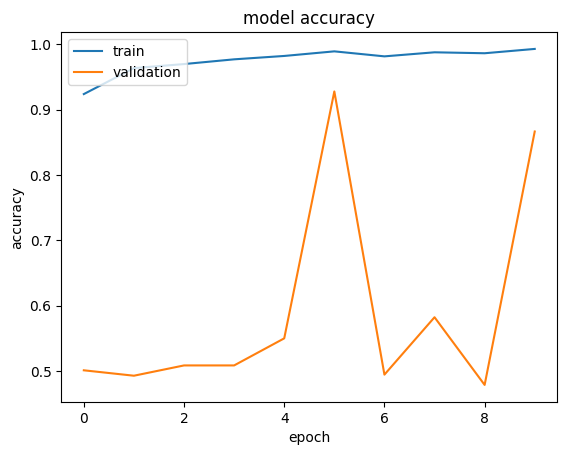

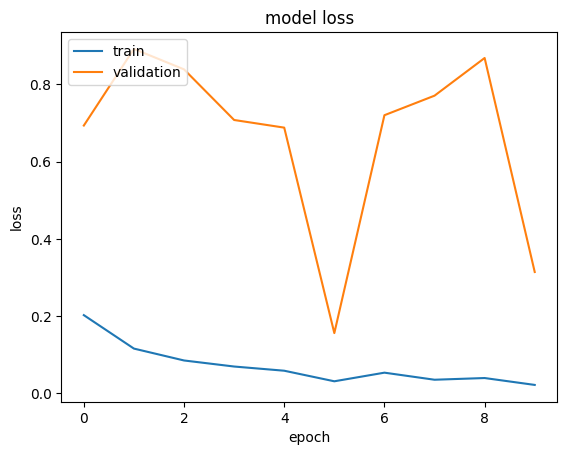

In [28]:
print("EfficientNetB0 Model Training Performance")
plot_history(enb0_history)

#### Observations
- Training loss appears to be decreasing continuously and accuracy increasing steadily
- However the validation loss and accuracy spike at around the 5th epoch and again at the 9th epoch
- Because the validation loss is higher and the accuracy lower than the training model, the model is likely overfitting

## Task B

### Build a Transfer Learning network using Keras with the following layers:

•Load ResNet50 as first layers using Keras API

•GLobalAveragePooling2D layer

•Dropout(0.5)

•Dense layer with 2 neurons and activation SoftMax (or 1 neuron with Sigmoid)


In [14]:
resnet_model = ResNet50(include_top=False)
model_res = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

### Compile the model with Adam optimizer,categorical_crossentropy loss and with metrics accuracy.

In [15]:
model_res.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

### Train the model for 10 epochs with callbacks Reduce Learning Rate on Plateau and early stopping while monitoring validation loss

In [16]:
res_history = model_res.fit(
    train_data,
    validation_data = train_data_validation,
    epochs=10,
    callbacks=[learning_rate_reduction, early_stopping]
)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 130s 738ms/step - accuracy: 0.8075 - loss: 0.5386 - val_accuracy: 0.4930 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 107s 701ms/step - accuracy: 0.9016 - loss: 0.2615 - val_accuracy: 0.4930 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 101s 664ms/step - accuracy: 0.9412 - loss: 0.1679 - val_accuracy: 0.5070 - val_loss: 0.7246 - learning_rate: 0.0010
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 111s 729ms/step - accuracy: 0.9287 - loss: 0.1841 - val_accuracy: 0.5145 - val_loss: 0.7703 - learning_rate: 0.0010
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 118s 778ms/step - accuracy: 0.9423 - loss: 0.1521 - val_accuracy: 0.7498 - val_loss: 0.5735 - learning_rate: 5.0000e-04
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 118s 777ms/step - accuracy: 0.9512 - loss: 0.1267 - val_accuracy: 0.8592 - val_loss: 0.3619 - learning_rate: 5.0000e-04
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 110s 722ms/step 

### Plot training and validation accuracy and loss against epochs

ResNet50 Model Training Performance


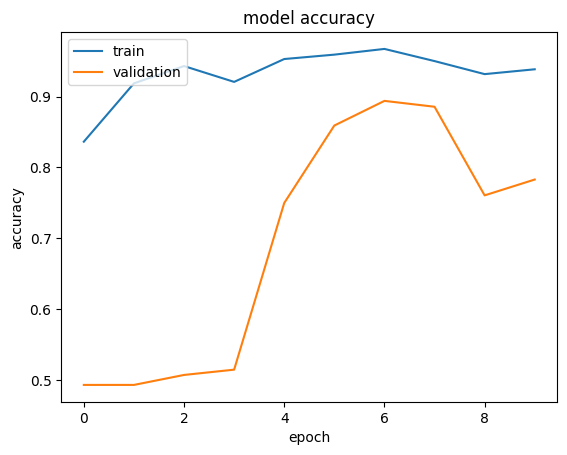

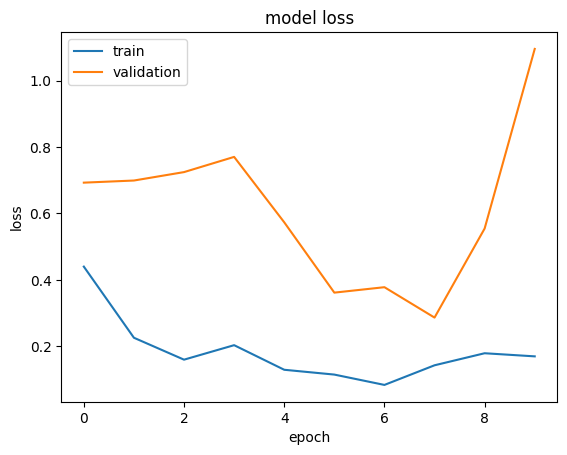

In [29]:
print("ResNet50 Model Training Performance")
plot_history(res_history)

#### Observations
- Trend for ResNet model shows improvement in accuracy annd decreasing loss
- ResNet model also appears to be overfitting given the validation accuracy being lower and the loss being higher than the training model

## Task C
### Compare EfficientNetB0 and ResNet50 model performance and find the best model

In [18]:
test_loss, test_accuracy = model_enb0.evaluate(test_data)
print(f"EfficientNetB0 Model Performance")
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.9094 - loss: 0.2233
EfficientNetB0 Model Performance
Test loss: 0.19874261319637299
Test accuracy: 0.9153439402580261


In [19]:
test_loss, test_accuracy = model_res.evaluate(test_data)
print(f"ResNet50 Model Performance")
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.7872 - loss: 1.1769
ResNet50 Model Performance
Test loss: 0.6173125505447388
Test accuracy: 0.8703703880310059


#### Observations
- EfficientNetB0 model performed better than the ResNet model, yielding 91% test accuracy and 87% test accuracy respectively
- As suspected, both models appear to be overfitting when compared to the test data, performing less accurate than on the training data

### Using the best model, predict the test dataset and plot 10 images from the test set along with its True Label and Predicted Label

In [20]:
mask_predict = model_enb0.predict(test_data)

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step


In [21]:
predicted_classes = np.argmax(mask_predict, axis=1)
predicted_df = pd.DataFrame(predicted_classes)
predicted_df.head(10)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [22]:
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())
test_data.class_indices

{'with': 0, 'without': 1}

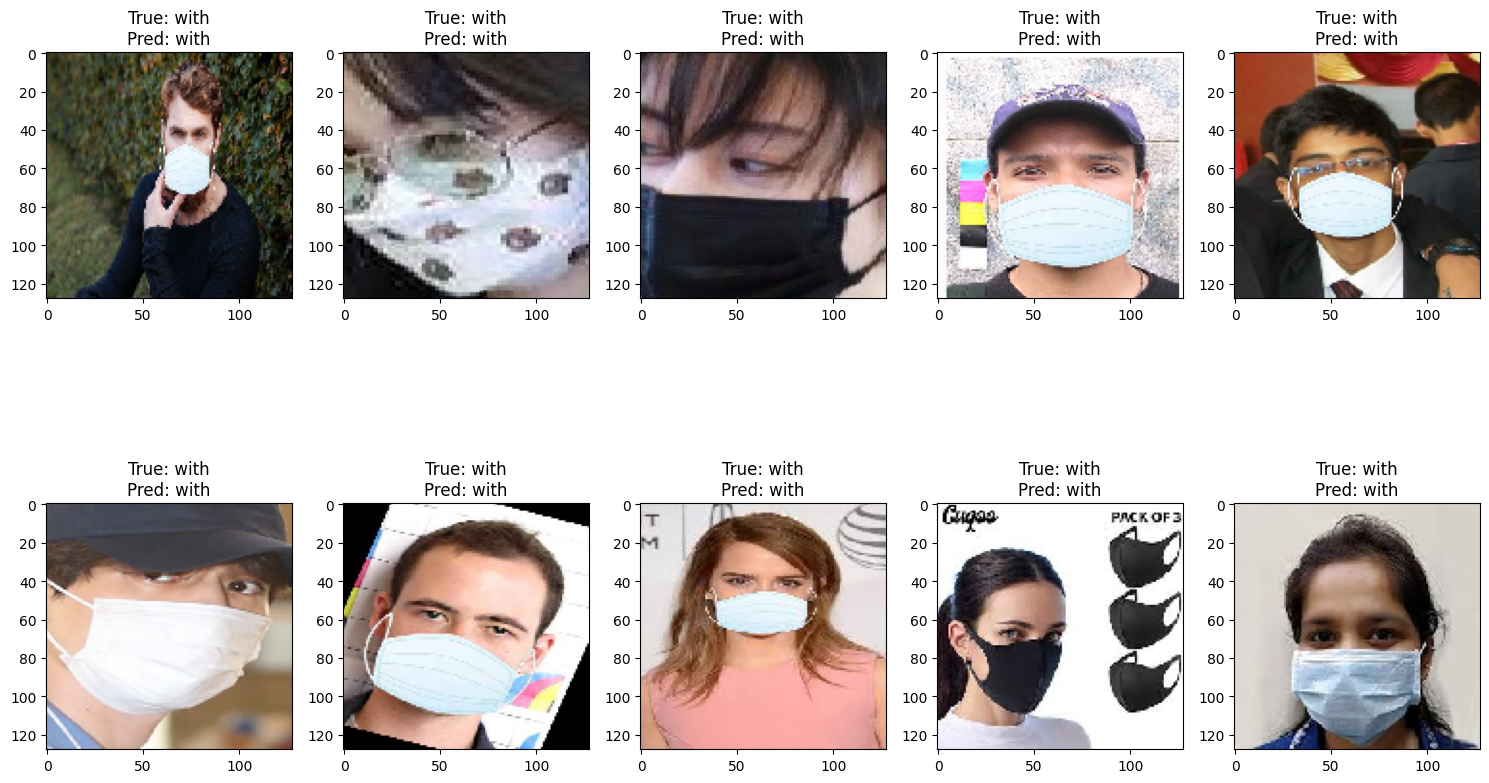

In [23]:
# Plot 10 images with true and predicted labels
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow((test_data[i][0][0]*255).astype(np.uint8))
    plt.title(f'True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}')

plt.tight_layout()
plt.show()

### Observations
- Model was able to correctly predict masked individuals in this batch of 10 images

# Conclusion
- EfficientNet model outperformed the ResNet model in classifying people wearing masks with less epochs.
- Both models appear to be overfitting and would benefit from possible tweaking to improve generalization, such as more drop out layers, adjusting learning rate, or adjusting early stopping